In [93]:
import pandas as pd 
import numpy as np
import seaborn as sns
import random
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input,Dropout,Dense,Activation,Convolution2D,MaxPooling2D,Flatten
from keras.optimizers import Adam,Adagrad,RMSprop
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
%matplotlib inline

In [121]:
## loading data
train_dir = '/Users/xingobar/Downloads/animal_train/'
test_dir = '/Users/xingobar/Downloads/animal_test/'

train_images = [ train_dir + str(i) for i in os.listdir(train_dir)]
dogs = [train_dir + str(i) for i in os.listdir(train_dir) if 'dog' in i]
cats = [train_dir + str(i) for i in os.listdir(train_dir) if 'cat' in i]
test_images = [test_dir + str(i) for i in os.listdir(test_dir)]

In [122]:
train_images = dogs[:1000] + cats[:1000]
test_images = test_images[:25]
random.shuffle(train_images)

In [123]:
rows  = 64
cols = 64
color_channel = 3
def read_image(images):
    img = cv2.imread(images,cv2.IMREAD_COLOR)
    return cv2.resize(img,(rows,cols),interpolation = cv2.INTER_CUBIC)

In [124]:
def prepare_data(images):
    image_length = len(images)
    data = np.ndarray((image_length,color_channel,rows,cols),dtype=np.uint8)
    for i,image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i % 250 ==0 : print '%d of %d '%(i,image_length)
    return data

In [125]:
train = prepare_data(train_images)
test = prepare_data(test_images)

0 of 2000 
250 of 2000 
500 of 2000 
750 of 2000 
1000 of 2000 
1250 of 2000 
1500 of 2000 
1750 of 2000 
0 of 25 


In [126]:
print 'train shape : ' ,train.shape
print 'test shape : ' , test.shape

train shape :  (2000, 3, 64, 64)
test shape :  (25, 3, 64, 64)


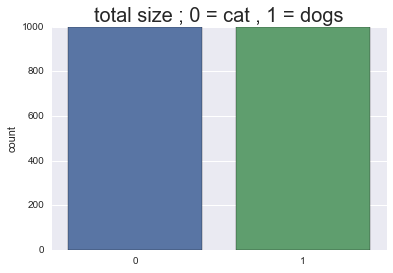

In [127]:
labels = []
for i in train_images:
    if 'dog' in i :
        labels.append(1)
    elif 'cat' in i:
        labels.append(0)
sns.countplot(labels)
plt.title('total size ; 0 = cat , 1 = dogs',fontsize=20)

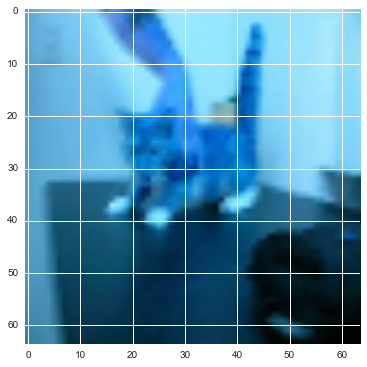

In [128]:
plt.figure(figsize=(18,6))
plt.imshow(read_image(cats[0]))
plt.show()

In [132]:
def CNN():
    model  =Sequential()
    model.add(Convolution2D(32,3,3,input_shape=(color_channel,rows,cols),border_mode='same',activation='relu'))
    model.add(Convolution2D(32,3,3,border_mode='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(64,3,3,border_mode='same',activation='relu'))
    model.add(Convolution2D(64,3,3,border_mode='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(128,3,3,border_mode='same',activation='relu'))
    model.add(Convolution2D(128,3,3,border_mode='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(256,3,3,border_mode='same',activation='relu'))
    model.add(Convolution2D(256,3,3,border_mode='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    
    #model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    
    #model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    
    return model
cnn = CNN()
    

In [133]:
nb_epoch = 10
batch_size = 16

## Callback for loss logging per epoch
class History(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_model():
    
    history = History()
    cnn.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = cnn.predict(test, verbose=0)
    return predictions, history

predictions, history = run_model()

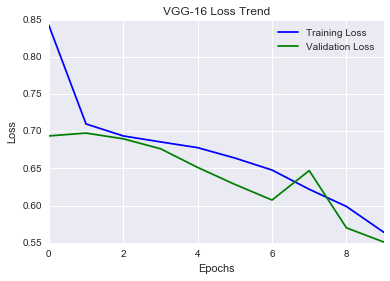

In [134]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

it is a dog 0.51 probability 


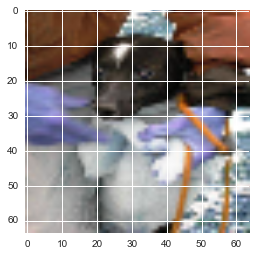

it is a cat  0.87 probability 


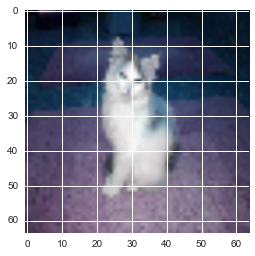

it is a cat  0.61 probability 


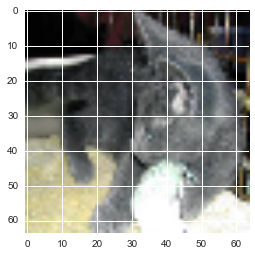

it is a dog 0.71 probability 


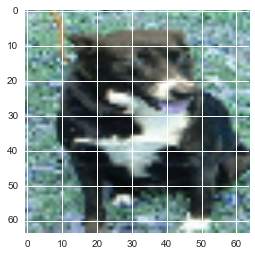

it is a dog 0.58 probability 


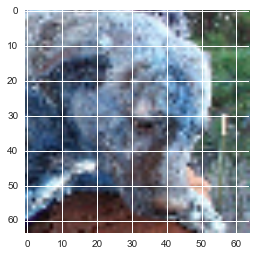

it is a cat  0.51 probability 


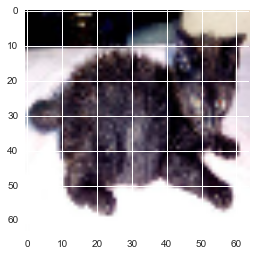

it is a cat  0.66 probability 


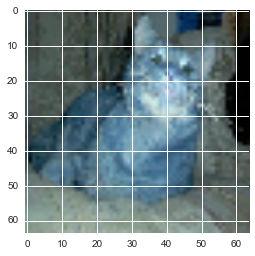

it is a dog 0.96 probability 


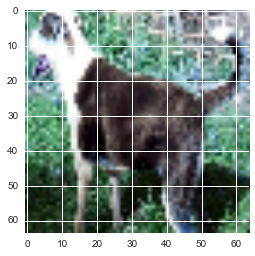

it is a dog 0.78 probability 


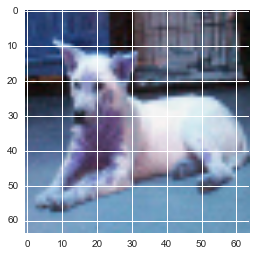

it is a cat  0.52 probability 


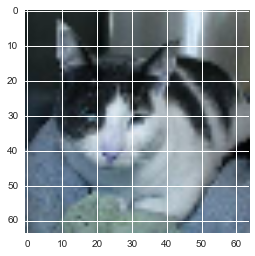

In [143]:
for i in range(0,10):
    if predictions[i,0] >=0.5 :
        print 'it is a dog %.2f probability ' %(predictions[i,0])
    else:
        print 'it is a cat  %.2f probability ' %(1 - predictions[i,0])
    plt.imshow(test[i].T)
    plt.show()